In [2]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))  
from tools.dictionary import *
from math import log10
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_company_financial_summary(db, code, path=None):
    quarter_cols= [s for s in db.columns.values if 'Q' in s]
    y = db.loc[(db['code']==code) & (db['fs_div']=='CFS'), ['account']+quarter_cols].set_index(['account'])
    date_updated = str(db.loc[(db['code']==code) & (db['fs_div']=='CFS'), 'date_updated'].values[0])
    y.columns = [s.replace('2020','XX').replace('20','').replace('XX','20').replace('_','.') for s in quarter_cols]
    yiu = y/KRW_UNIT 

    yiu.loc['opmargin', :] = yiu.loc['operating_income']/yiu.loc['revenue']*100
    yiu.loc['liquid_asset_ratio', :] = yiu.loc['liquid_assets']/yiu.loc['assets']*100
    yiu.loc['liquid_debt_ratio', :] = yiu.loc['liquid_debts']/yiu.loc['debts']*100
    yiu.loc['debt_to_equity_ratio', :] = yiu.loc['debts']/yiu.loc['equity']*100

    f, ax = plt.subplots(4, 1, figsize=(20, 15), constrained_layout=True, gridspec_kw={'height_ratios': [5, 3, 3, 3]})
    f.set_constrained_layout_pads(w_pad=0, h_pad=0.1, hspace=0, wspace=0.)
    sns.set_theme(style="dark")
    sns.despine(left=True, bottom=False)
    _plot_barline(ax[0], yiu, 'revenue', 'operating_income', 'opmargin', 'profit_before_tax')
    _plot_barline(ax[1], yiu, 'assets', 'liquid_assets', 'liquid_asset_ratio')
    _plot_barline(ax[2], yiu, 'debts', 'liquid_debts', 'liquid_debt_ratio')
    _plot_barline(ax[3], yiu, 'equity', 'retained_earnings', 'debt_to_equity_ratio')

    df_krx = pd.read_feather('data/df_krx.feather')
    name = df_krx['Name'][code]

    kor_ft={'font':'NanumGothic'}
    f.suptitle('Consolidated Financial Statement Summary - company: '+name+'('+code+') updated on '+date_updated, fontsize=14, fontdict=kor_ft)
    if path==None: 
        plt.show()
    else: 
        plt.savefig(path)


def _plot_barline(ax, data, y1, y2, y3, y4=None):
    axr = ax.twinx()
    if y4 != None:
        tx = data.loc[y1].isnull()*data.loc[y2].isnull().values*data.loc[y4].isnull().values
    else: 
        tx = data.loc[y1].isnull()*data.loc[y2].isnull().values
    x = [s for s in data.columns.values if not tx[s]]

    sns.set_color_codes("pastel")
    sns.barplot(x=x, y=data.loc[y1, x], ax = ax, label=y1, color="b")
    ax.ticklabel_format(axis='y', scilimits=[-3, 3])
    t_ = ax.get_yticklabels()[-1].get_position()[1] / float(ax.get_yticklabels()[-1].get_text())

    unit_list = ['uk_won','10 uk_won','100 uk_won','1,000 uk_won', 'jo_won', '10 jo_won', '100 jo_won']
    unit_exp = unit_list[int(log10(t_))]

    for index, value in enumerate(data.loc[y1, x]):
        try:
            v = str(round(value/t_, 1))
            ax.text(index, value, v)
        except: 
            pass

    sns.set_color_codes("muted")
    sns.barplot(x=x, y=data.loc[y2, x], ax = ax, label=y2, color="b")
    for index, value in enumerate(data.loc[y2, x]):
        try:
            v = str(round(value/t_, 1))
            ax.text(index, value, v)
        except: 
            pass

    if y4 != None:
        sns.lineplot(x=x, y=data.loc[y4, x], ax = ax, label=y4, color="k", marker='^')
        for index, value in enumerate(data.loc[y4, x]):
            try:
                v = str(round(value/t_, 1))
                ax.text(index, value, v)
            except: 
                pass

    ax.legend(ncol=1, loc="upper left", frameon=False)
    ax.set(ylabel=KRW_UNIT_STR)
    if y4 != None:
        ax.set_title(y1+', '+y2+', '+y4+', '+y3+' (unit: '+unit_exp+')')
    else: 
        ax.set_title(y1+', '+y2+', '+y3+' (unit: '+unit_exp+')')

    sns.lineplot(x=x, y=data.loc[y3, x], ax = axr, label=y3+'(%)', color="r", marker='o')
    for index, value in enumerate(data.loc[y3, x]):
        try:
            v = str(round(value, 1))
            axr.text(index, value, v)
        except: 
            pass

    axr.legend(ncol=1, loc="upper left", frameon=False, bbox_to_anchor=(0, 0.8))
    axr.set(ylabel="percent(%)")

    ax.set_xlim(-0.5, len(x) - 0.5)
    axr.set_xlim(-0.5, len(x) - 0.5)

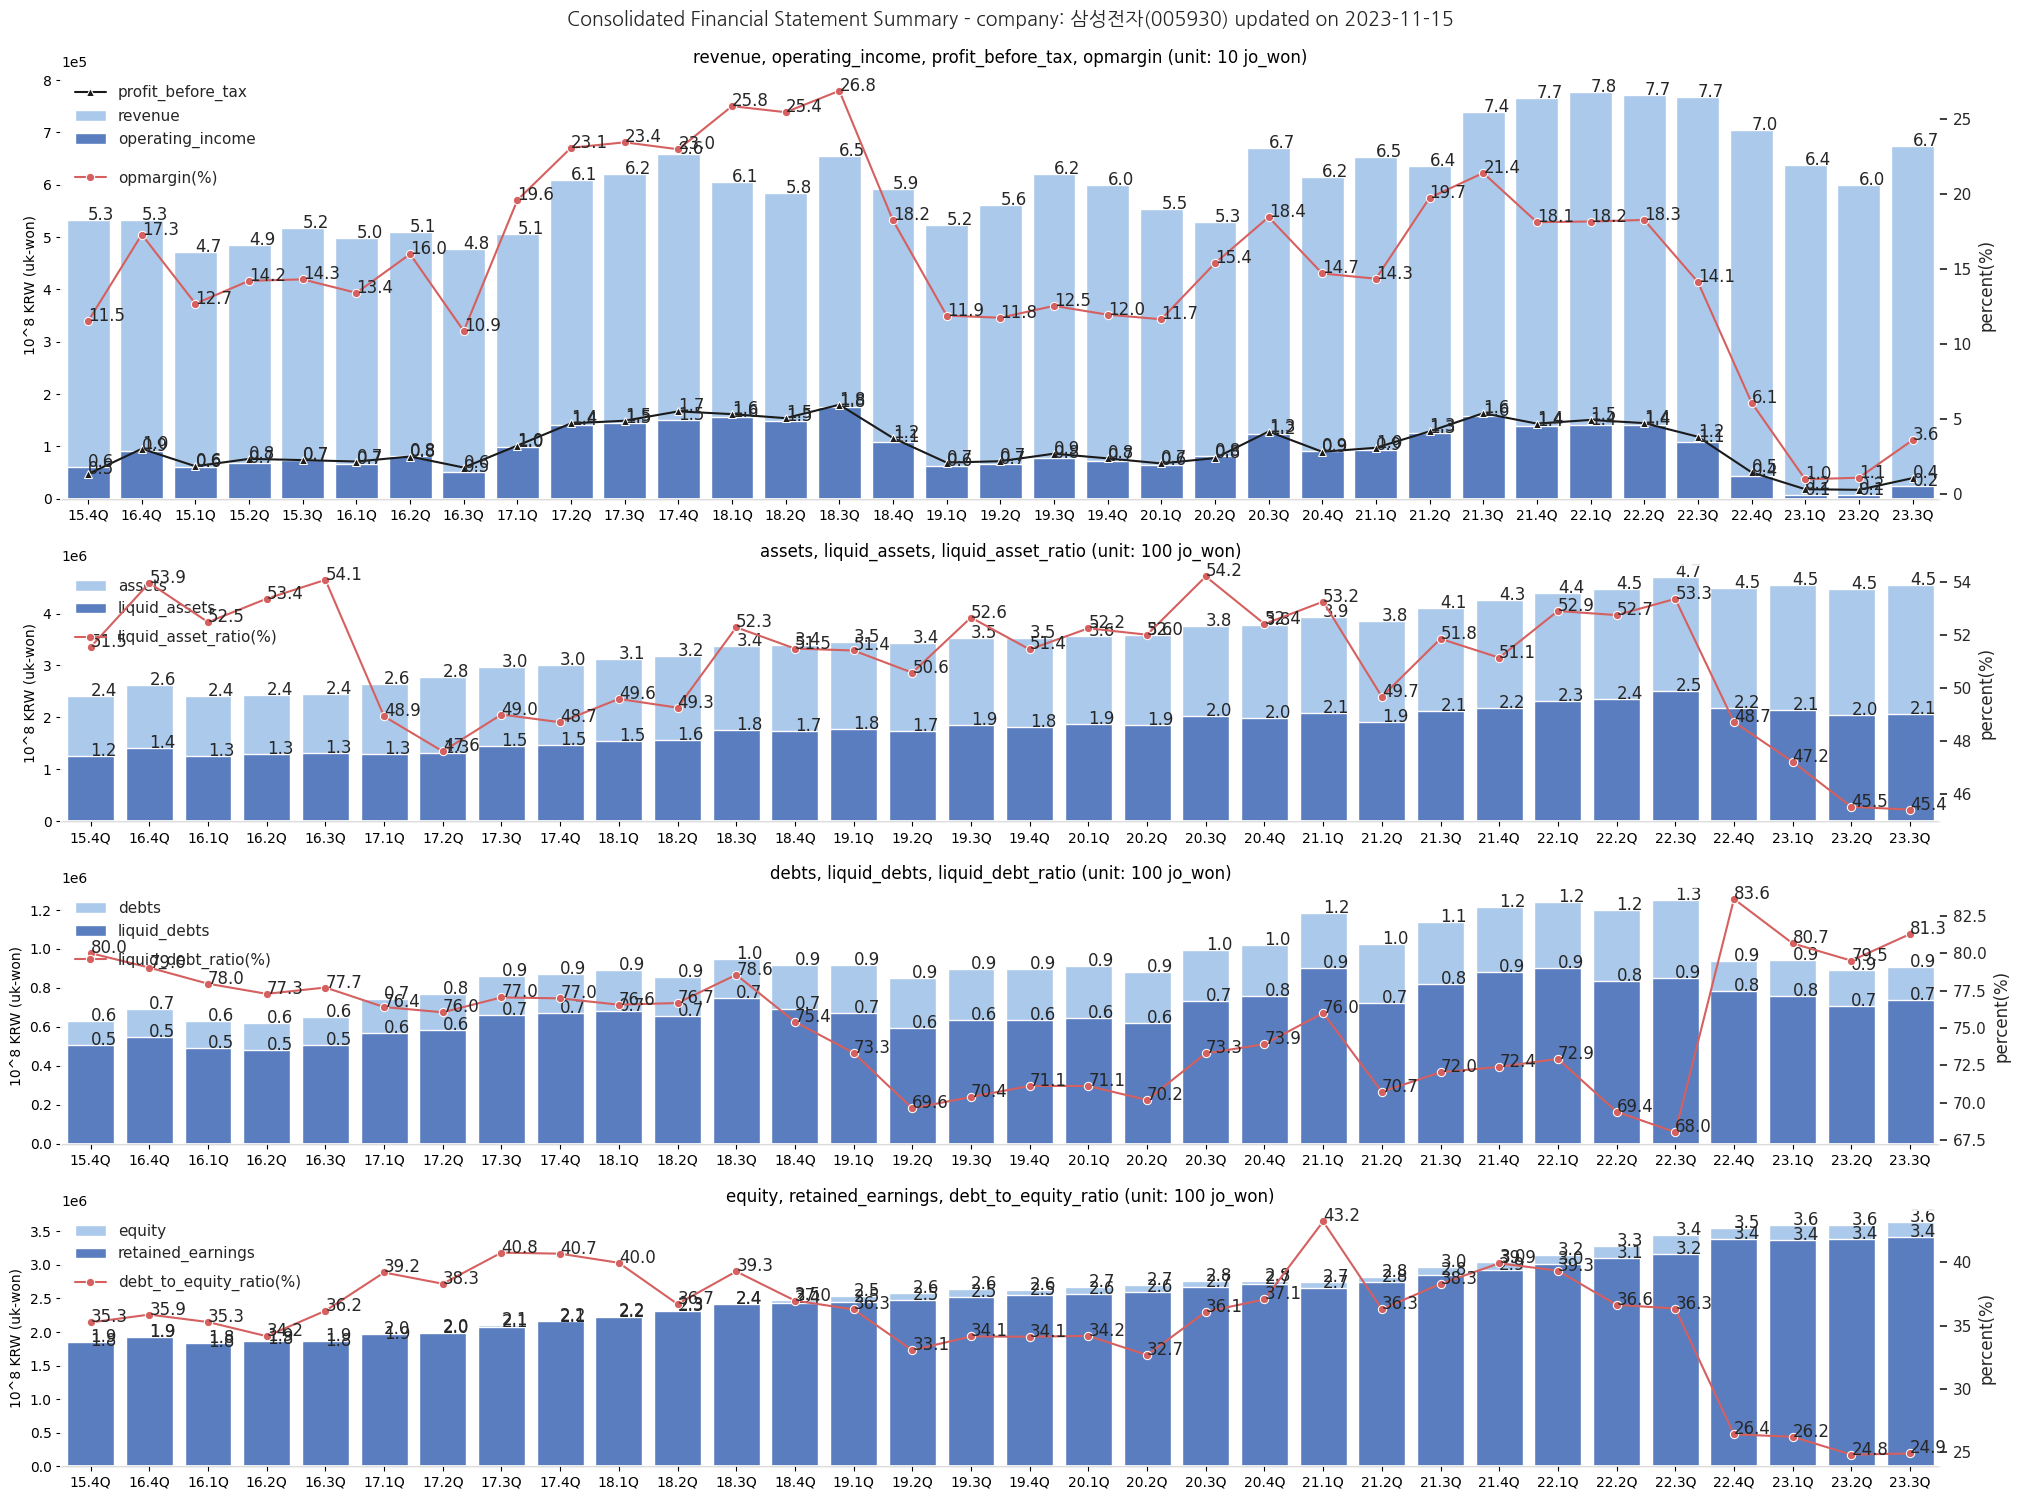

In [3]:
db = pd.read_feather('data/financial_reports_main.feather')
code = '005930'
path = 'plots/'+code+'.png'
plot_company_financial_summary(db, code, path)